# Zillow Webscraper

By: Kyle Perez

Web scraping is a powerful technique for harvesting data from websites, offering diverse applications. In this notebook, we'll explore the process of extracting information from the well-known real estate website Zillow. Please note that Zillow has measures to mitigate automated scraping, as outlined in their Terms and Conditions. To avoid potential issues, refrain from running the program multiple times in quick succession.

## Project Purpose

The primary objective of this project is to harvest real estate data for personal record-keeping, aiding in the process of purchasing a home. By leveraging web scraping techniques on platforms like Zillow, we aim to gather valuable insights and information to inform our home-buying decisions.

The URL is a saved search from zillow with the home attributes I am looking for. 

In [1]:
# Importing enviorments needed 
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

# Targeted URL
url = 'https://www.zillow.com/grand-junction-co/?searchQueryState=%7B%22isMapVisible%22%3Afalse%2C%22mapBounds%22%3A%7B%22north%22%3A39.366227%2C%22south%22%3A38.871492%2C%22east%22%3A-108.293509%2C%22west%22%3A-108.749487%7D%2C%22mapZoom%22%3A7%2C%22usersSearchTerm%22%3A%22Mesa%2C%20CO%22%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22price%22%3A%7B%22min%22%3A0%2C%22max%22%3A450000%7D%2C%22mp%22%3A%7B%22min%22%3A0%2C%22max%22%3A2285%7D%2C%22beds%22%3A%7B%22min%22%3A2%2C%22max%22%3Anull%7D%2C%22baths%22%3A%7B%22min%22%3A1%2C%22max%22%3Anull%7D%2C%22tow%22%3A%7B%22value%22%3Afalse%7D%2C%22mf%22%3A%7B%22value%22%3Afalse%7D%2C%22con%22%3A%7B%22value%22%3Afalse%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%2C%22apa%22%3A%7B%22value%22%3Afalse%7D%2C%22apco%22%3A%7B%22value%22%3Afalse%7D%7D%2C%22isListVisible%22%3Atrue%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A31819%2C%22regionType%22%3A6%7D%5D%2C%22pagination%22%3A%7B%7D%7D'

### Implementation Strategy

To ensure uninterrupted data harvesting and avoid potential blocking, we will set a 'user_agent' to disguise our program as a human browser. Additionally, since Zillow webpages employ Javascript for dynamic loading, we'll utilize the Selenium WebDriver to programmatically scroll through the pages and load all the listings. This approach enables us to comprehensively scrape the desired real estate data from Zillow.

This will require you to have Google Webdrivers installed on pc. 

In [2]:
# Set user-agent
user_agent = "'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"

# Options for the Chrome browser
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument(f"user-agent={user_agent}")

# Initialize a Selenium webdriver
driver = webdriver.Chrome(options=chrome_options)  # You need to have ChromeDriver installed and in your PATH

# Open the page with Selenium
driver.get(url)

# Scroll down to load more content
for _ in range(10):  # Scroll down 10 times
    driver.find_element("tag name", 'body').send_keys(Keys.END)
    time.sleep(2)  # Wait for the content to load

# Get the page source code after scrolling
page_source = driver.page_source

# Close webdriver
driver.quit()

## Data Extraction Process

After successfully scrolling through the page using Selenium WebDriver, we will proceed to gather HTML data. Our focus will be on isolating the specific container that encapsulates the listing data. This targeted approach streamlines the extraction process, allowing us to efficiently capture the relevant real estate information for further analysis.

### HTML Inspection for Data Identification

To proceed with our analysis, we begin by inspecting the HTML code of our targeted URL. This process enables us to identify specific pointers to the information we seek.

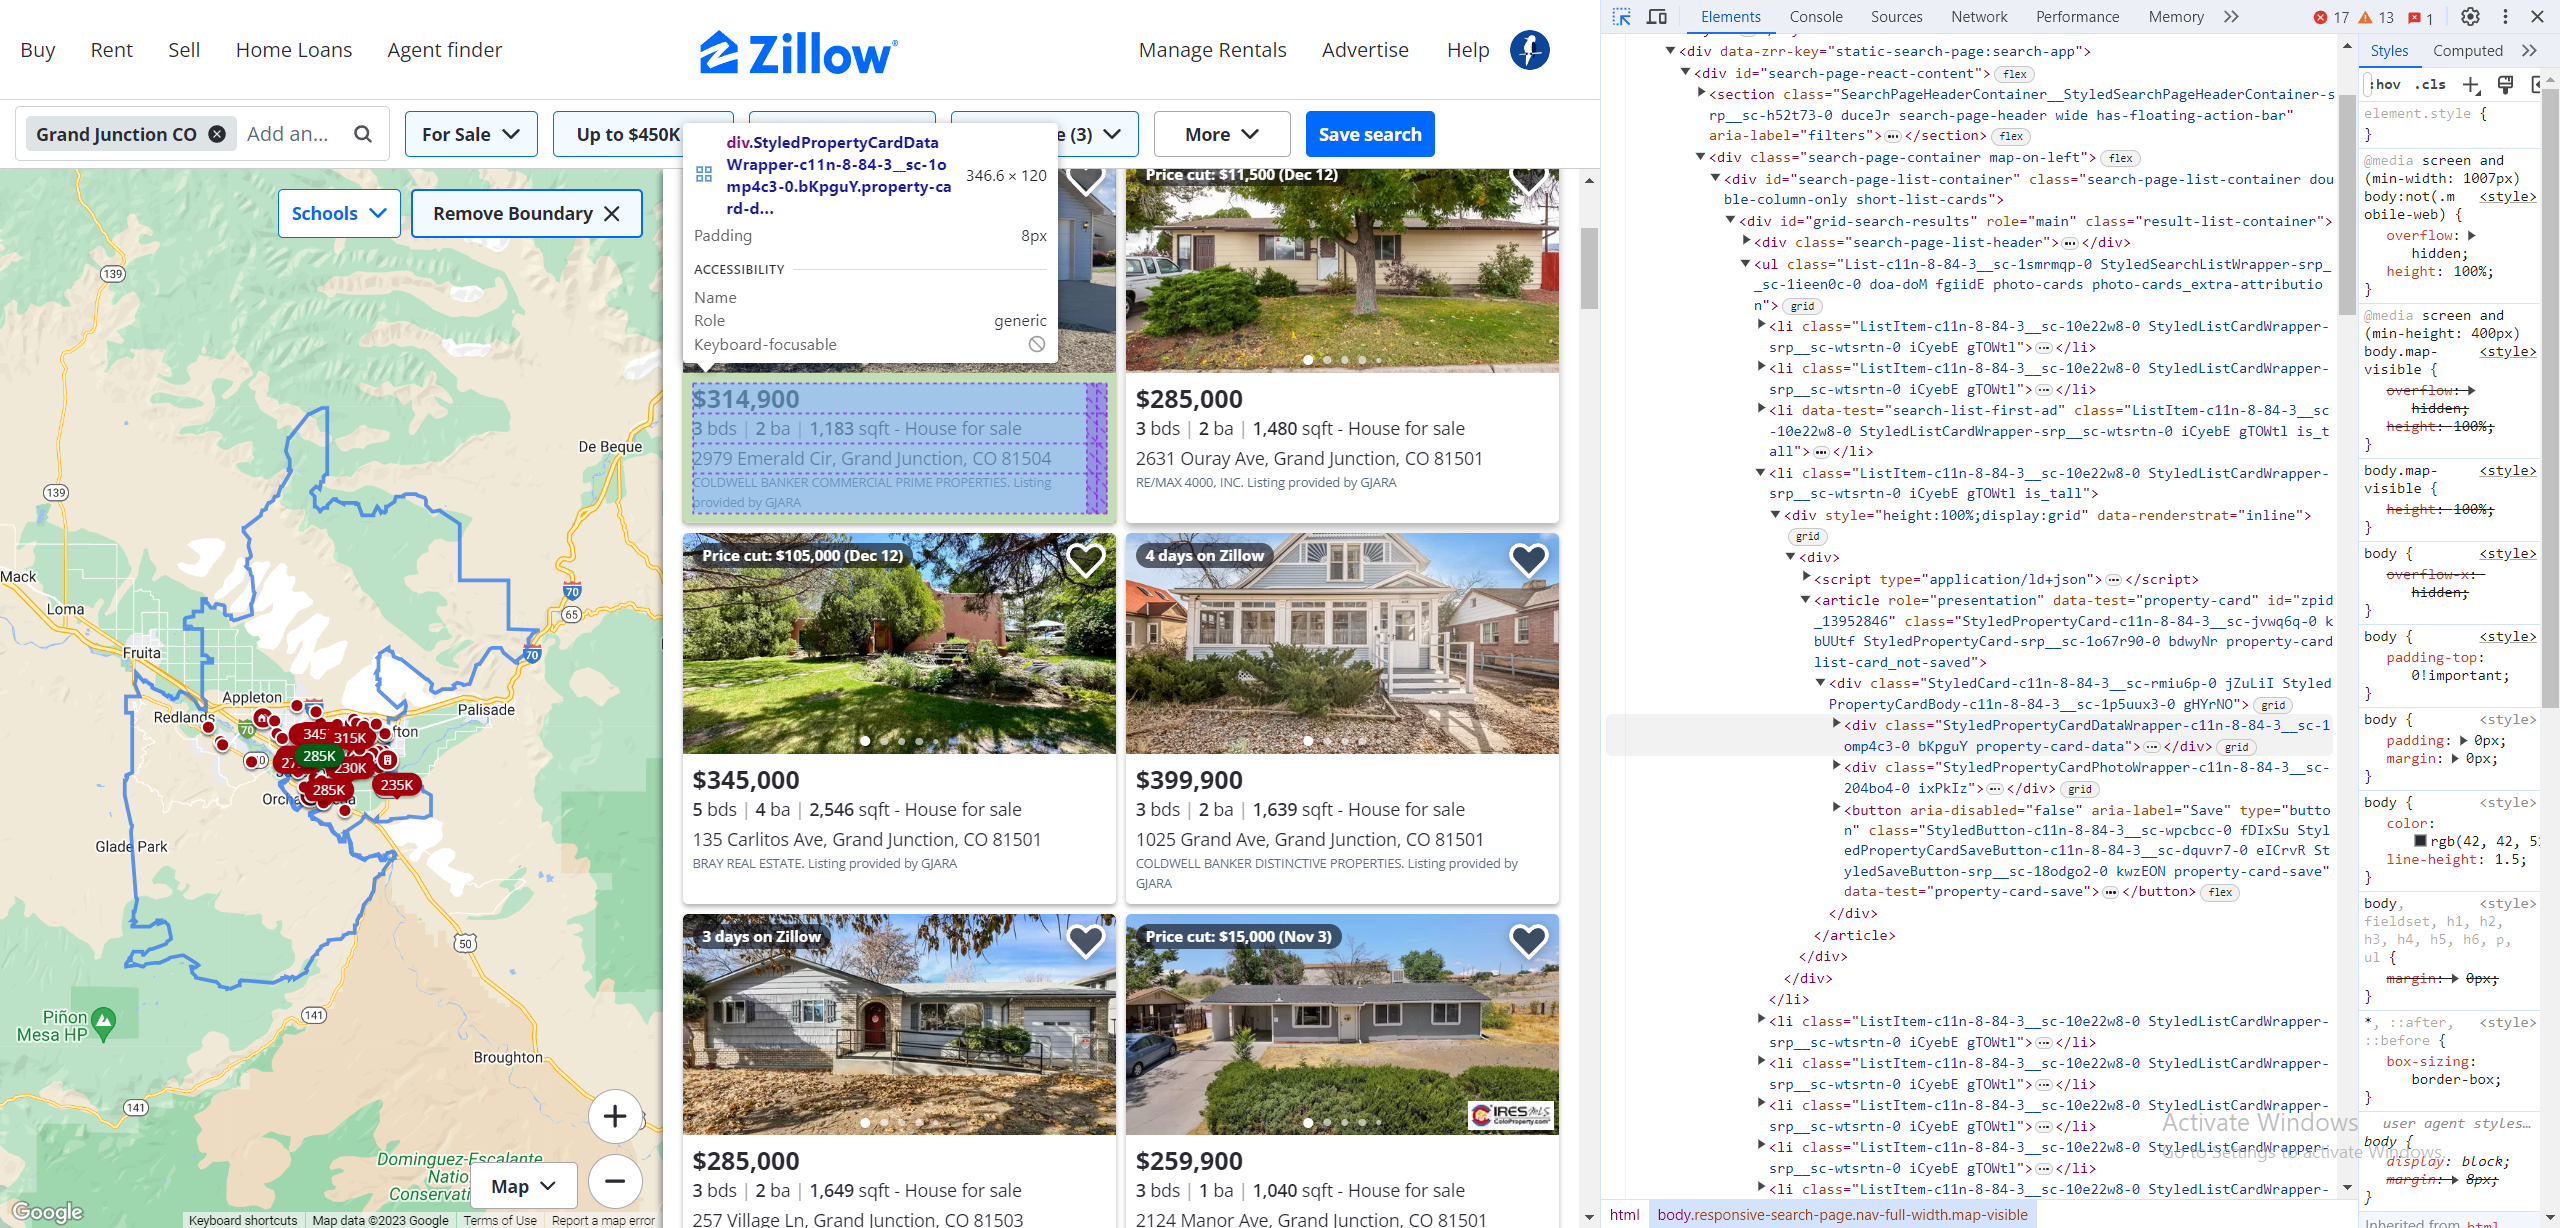

Upon inspection, we found that our data cards are located within a 'div' with the class 'StyledPropertyCardDataWrapper-c11n-8-84-3__sc-1omp4c3-0 bKpguY property-card-data'.

In [3]:
# Parse the page source with BeautifulSoup
soup = BeautifulSoup(page_source, 'html.parser')

# Extract listing data cards 
results = soup.find_all('div', class_= 'StyledPropertyCardDataWrapper-c11n-8-84-3__sc-1omp4c3-0 bKpguY property-card-data')

# Print amount of data cards scraped their HTML 
print('Number of listing datacards: ', len(results))
print('Sample Data Card: ')
print(results[0])

Number of listing datacards:  32
Sample Data Card: 
<div class="StyledPropertyCardDataWrapper-c11n-8-84-3__sc-1omp4c3-0 bKpguY property-card-data"><a class="StyledPropertyCardDataArea-c11n-8-84-3__sc-yipmu-0 jnnxAW property-card-link" data-test="property-card-link" href="https://www.zillow.com/homedetails/135-Carlitos-Ave-Grand-Junction-CO-81501/13967641_zpid/" tabindex="0"><address data-test="property-card-addr">135 Carlitos Ave, Grand Junction, CO 81501</address></a><div class="StyledPropertyCardDataArea-c11n-8-84-3__sc-yipmu-0 jretvB">BRAY REAL ESTATE. Listing provided by GJARA</div><div class="StyledPropertyCardDataArea-c11n-8-84-3__sc-yipmu-0 fDSTNn"><div class="PropertyCardWrapper__StyledPriceGridContainer-srp__sc-16e8gqd-0 kSsByo"><span class="PropertyCardWrapper__StyledPriceLine-srp__sc-16e8gqd-1 iMKTKr" data-test="property-card-price">$345,000</span></div></div><div class="StyledPropertyCardDataArea-c11n-8-84-3__sc-yipmu-0 dbDWjx"><ul class="StyledPropertyCardHomeDetailsList-c

### Data Extraction Function

Following the isolation of containers containing listing data, we will develop a custom function to extract the desired information. The function will collect data such as address, price, bedrooms, bathrooms, square footage, and the listing link. The extracted data will be organized into a DataFrame, providing a structured format.

In [4]:
data_list = []

for result in results:
    address = result.find('address', {'data-test': 'property-card-addr'}).text
    price = result.find('span', class_ = 'PropertyCardWrapper__StyledPriceLine-srp__sc-16e8gqd-1 iMKTKr').text
    
    # Find parent container with details class
    ul_tag = result.find('ul', class_='StyledPropertyCardHomeDetailsList-c11n-8-84-3__sc-1xvdaej-0 eYPFID')

    # Extract listing details
    bed = ul_tag.find('li').b.get_text()
    bath = ul_tag.find_all('li')[1].b.get_text()
    sqft = ul_tag.find_all('li')[2].b.get_text()
    
    # Find listing weblink parent container
    property_link = result.find('a', class_='StyledPropertyCardDataArea-c11n-8-84-3__sc-yipmu-0 jnnxAW property-card-link')
    
    # Extract listing weblink
    if property_link:
        url = property_link.get('href')
    else:
        url = 'None' 
   
    # Append data to the list as a dictionary
    data_list.append({'Address': address, 'Price': price, 'Bedrooms': bed, 'Bathrooms': bath, 'SquareFeet': sqft, 'ZillowLink': url})

# Convert to a DataFrame
df = pd.DataFrame(data_list)

In [5]:
df.head()

,Address,Price,Bedrooms,Bathrooms,SquareFeet,ZillowLink
0,"135 Carlitos Ave, Grand Junction, CO 81501","$345,000",5,4,"2,546",https://www.zillow.com/homedetails/135-Carlito...
1,"1025 Grand Ave, Grand Junction, CO 81501","$399,900",3,2,"1,639",https://www.zillow.com/homedetails/1025-Grand-...
2,"257 Village Ln, Grand Junction, CO 81503","$285,000",3,2,"1,649",https://www.zillow.com/homedetails/257-Village...
3,"2124 Manor Ave, Grand Junction, CO 81501","$259,900",3,1,"1,040",https://www.zillow.com/homedetails/2124-Manor-...
4,"3257 Tyler Ct, Grand Junction, CO 81503","$234,900",3,2,"1,357",https://www.zillow.com/homedetails/3257-Tyler-...


## Pipeline

We have successfully scraped the desired data from the webpage, we will now send the data through a pipeline to make it more usable.<br> The following transformations will be made:

- The 'Address' column will be separated into four separate columns: 'Street', 'City', 'State', and 'Zip'.
- 'Price', 'Bedrooms', 'Bathrooms', and 'SquareFeet' will be converted to integers for future analysis.

In [6]:
# Split the 'Address' column into 'Street', 'City', 'State', and 'Zip'
address_parts = df['Address'].str.split(', ', expand=True)

In [7]:
# Extract State and Zip
state_zip_parts = address_parts[2].str.split(' ')

In [8]:
df = df.assign(Street=address_parts[0],
               City=address_parts[1],
               State=state_zip_parts.str[0],
               Zip=state_zip_parts.str[1])

In [9]:
# Convert numerical columns to int
df[['Price', 'SquareFeet']] = df[['Price', 'SquareFeet']].replace('[\$,]', '', regex=True).astype(int)
df[['Bedrooms', 'Bathrooms']] = df[['Bedrooms', 'Bathrooms']].astype(int)

In [10]:
# Rearrange columns and drop 'Address'
df = df[['Street', 'City', 'State', 'Zip', 'Price', 'Bedrooms', 'Bathrooms', 'SquareFeet', 'ZillowLink']]

In [11]:
df

,Street,City,State,Zip,Price,Bedrooms,Bathrooms,SquareFeet,ZillowLink
0,135 Carlitos Ave,Grand Junction,CO,81501,345000,5,4,2546,https://www.zillow.com/homedetails/135-Carlito...
1,1025 Grand Ave,Grand Junction,CO,81501,399900,3,2,1639,https://www.zillow.com/homedetails/1025-Grand-...
2,257 Village Ln,Grand Junction,CO,81503,285000,3,2,1649,https://www.zillow.com/homedetails/257-Village...
3,2124 Manor Ave,Grand Junction,CO,81501,259900,3,1,1040,https://www.zillow.com/homedetails/2124-Manor-...
4,3257 Tyler Ct,Grand Junction,CO,81503,234900,3,2,1357,https://www.zillow.com/homedetails/3257-Tyler-...
5,2975 Red Willow Dr,Grand Junction,CO,81504,229900,3,2,1404,https://www.zillow.com/homedetails/2975-Red-Wi...
6,643 Brooks Ct,Grand Junction,CO,81504,374643,3,2,1568,https://www.zillow.com/homedetails/643-Brooks-...
7,630 Stonegate Dr,Grand Junction,CO,81504,395000,3,2,1877,https://www.zillow.com/homedetails/630-Stonega...
8,3178 1/2 Orson Ave,Grand Junction,CO,81504,324900,3,2,1188,https://www.zillow.com/homedetails/3178-1-2-Or...
9,495 McMullin Dr,Grand Junction,CO,81504,270000,4,2,1472,https://www.zillow.com/homedetails/495-McMulli...


## Data Validation and Storage

With the data successfully harvested and structured in the DataFrame, our final steps involve validating for any null values to ensure data integrity. Once verified, we will save the DataFrame as a CSV file for convenient storage and future reference in our records.

In [12]:
df.isnull().sum()

Street        0
City          0
State         0
Zip           0
Price         0
Bedrooms      0
Bathrooms     0
SquareFeet    0
ZillowLink    0
dtype: int64

In [13]:
df.to_csv('zillow_data.csv', index=False)